<b>Анализ пользовательского поведения в мобильном приложении</b>

<b> Описание проекта </b><br>

Задачи <br>
* Изучить воронку продаж и понять где мы теряем пользователей и как в целом дела по переходу к оплате и дать рекоендации.
* Разработчики внерили новые шрифты и хотят узнать по результатам A/A/B-теста что из этого вышло и стоит ли их внедрять.
группы А/А - старые шрифты, В - новые.


<b>Описание данных</b>
Каждая запись в логе — это действие пользователя, или событие. 
* EventName — название события;
* DeviceIDHash — уникальный идентификатор пользователя;
* EventTimestamp — время события;
* ExpId — номер эксперимента: 246 и 247 — контрольные группы, а 248 — экспериментальная.<br>


## Шаг: Откроем файл с данными и изучим общую информацию

In [1]:
# Необходимые библиотеки для исследования 
import pandas as pd
import matplotlib.pyplot as plt
import math as mth
from scipy import stats as st
from plotly import graph_objects as go
from datetime import datetime
import numpy as np
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [5]:
# открываем файл с данными
logs=pd.read_csv('/datasets/logs_exp.csv', delimiter='\t') 

In [6]:
display(logs.head())

,EventName,DeviceIDHash,EventTimestamp,ExpId
0,MainScreenAppear,4575588528974610257,1564029816,246
1,MainScreenAppear,7416695313311560658,1564053102,246
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248
3,CartScreenAppear,3518123091307005509,1564054127,248
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248


На этом шаге мы загрузили необходимые библиотеки, загрузили файл с данными.
На следующем шаге проанализииуем данные и подготовим их для дальнейшей работы

## Шаг: Подготовим данные

### Заменим названия столбцов на удобные 

In [7]:
# Приведем названия столбцов к нижнему регистру и более понятным названиям
logs.columns = ['event', 'device', 'timestamp', 'group']

### Проверим пропуски и типы данных

In [8]:
logs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   event      244126 non-null  object
 1   device     244126 non-null  int64 
 2   timestamp  244126 non-null  int64 
 3   group      244126 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 7.5+ MB


Пропусков в данных нет

In [9]:
# проверим количество полных дубликатов в датасете, кол-во полных дубликатов (совпадает вся строка) равно 0
logs.duplicated().sum()

413

Найдено 413 дубликатов из общего количесвта 244126 строк, это очень маленькая часть от общего числа, их можно удаить 

In [10]:
logs=logs.drop_duplicates()
logs.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 243713 entries, 0 to 244125
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   event      243713 non-null  object
 1   device     243713 non-null  int64 
 2   timestamp  243713 non-null  int64 
 3   group      243713 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 9.3+ MB


In [11]:
# проверим пользователей на аномалии - вхождение в несколько групп сразу
logs.groupby('device').agg({'group': pd.Series.nunique}).query('group == 2').count()

group    0
dtype: int64

Одинаковых пользователей в группах нет.

### Добавим столбец даты и времени, а также отдельный столбец дат

In [12]:
# дабавим столбец даты и времени в понятном виде, тип datetime:
logs["time"] = pd.to_datetime(logs['timestamp'], unit="s")
# добавим столбец дат
logs['date'] = logs.time.dt.date
display(logs.head())

,event,device,timestamp,group,time,date
0,MainScreenAppear,4575588528974610257,1564029816,246,2019-07-25 04:43:36,2019-07-25
1,MainScreenAppear,7416695313311560658,1564053102,246,2019-07-25 11:11:42,2019-07-25
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248,2019-07-25 11:28:47,2019-07-25
3,CartScreenAppear,3518123091307005509,1564054127,248,2019-07-25 11:28:47,2019-07-25
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248,2019-07-25 11:48:42,2019-07-25


На этом этапе мы выявили полные дубликаты и их удалили, преобразовали время к удобному формату datetime и добавили столбец его в столбец time, также выделили из времени только дату и добавили столбец дат. На следующем этапе изучим и проверим данные

## Шаг: Изучим и проверим данные

### Сколько всего событий в логе?

In [13]:
# Сколько всего событий в логе?
print('Всего событий в логе: {}'.format(len(logs)))

Всего событий в логе: 243713


### Сколько всего пользователей в логе?

In [14]:
# Сколько всего пользователей в логе?
print('Всего пользователей в логе: {}'.format(logs['device'].nunique()))

Всего пользователей в логе: 7551


### Сколько в среднем событий приходится на пользователя?

In [15]:
# Сколько в среднем событий приходится на пользователя?
print('Среднее кол-во событий, которые приходятся на пользователя: {}'.format(round(len(logs)/logs['device'].nunique())))

Среднее кол-во событий, которые приходятся на пользователя: 32


### Данными за какой период у нас есть? Найдем максимальную и минимальную дату. Построим гистограмму по дате и времени. Определим, с какого момента данные полные и отбросим более старые. 

In [16]:
print('максимальная дата: {}'.format(logs['date'].max()), ', минимальная дата: {}'.format(logs['date'].min()) )

максимальная дата: 2019-08-07 , минимальная дата: 2019-07-25


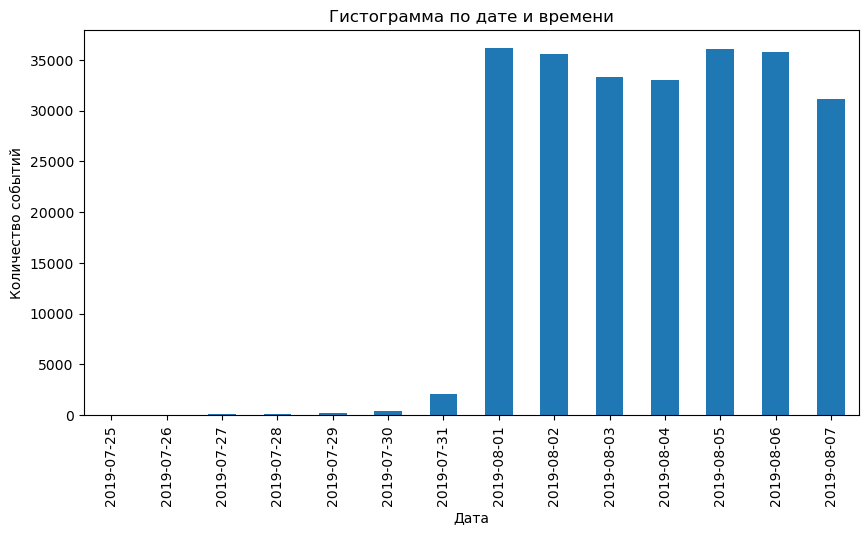

In [17]:
time_gr = logs.groupby('date')['time'].count().reset_index()
(time_gr.plot(kind='bar',x='date', y='time',figsize=(10, 5),legend=False)
                         .set(xlabel='Дата', ylabel='Количество событий')
)
plt.title('Гистограмма по дате и времени')
plt.show()

По гистограмме видно, что полные данные у нас с 2019-08-01 по 2019-08-07.
Отбросим данные до 2019-08-01

In [18]:
logs_august = logs[logs['date'] >= pd.to_datetime('2019-08-01')]

### Много ли событий и пользователей мы потеряли, отбросив старые данные?

In [19]:
print('Было потеряно: {}'.format(len(logs)-len(logs_august)), 'событий и' )
print('было потеряно: {}'.format(logs['device'].nunique()-logs_august['device'].nunique()), 'пользователей')
print('Рассмотрим эти цифры в процентах')
print('Было потеряно: {}'.format(round(100-len(logs_august)/len(logs)*100,2)),'% событий и' )
print('было потеряно: {}'.format(round(100-logs_august['device'].nunique()/logs['device'].nunique()*100,2)),'% пользователей')

Было потеряно: 2826 событий и
было потеряно: 17 пользователей
Рассмотрим эти цифры в процентах
Было потеряно: 1.16 % событий и
было потеряно: 0.23 % пользователей


Видим, что потеряно было около 1% событий и менее 1% пользователей, на общий результат это не окажет сильного влияния.

### Проверим, что у нас есть пользователи из всех трёх экспериментальных групп.

In [20]:
print('Всего групп: {}'.format(logs['group'].nunique()))

Всего групп: 3


In [21]:
logs_august.groupby('group')['device'].nunique()

group
246    2484
247    2513
248    2537
Name: device, dtype: int64

Пользователи есть в каждой группе и их количество примерно одинаковое

На этом шаге мы проанализировали данные, определили что полные данные у нас с 2019-08-01 по 2019-08-07, отбросили данные до 2019-08-01, проанализировали сколько событий и пользоватлей было потеряно. Также проверили наличие пользователей во всех 3х группах.
На следующем шаге построим и изучим воронку событий

## Шаг: Изучим воронку событий

### Посмотрим, какие события есть в логах, как часто они встречаются. Отсортируем события по частоте.

In [22]:
# считаем частоту событий
events = logs_august['event'].value_counts().sort_values(ascending = False)
display(events)

MainScreenAppear           117328
OffersScreenAppear          46333
CartScreenAppear            42303
PaymentScreenSuccessful     33918
Tutorial                     1005
Name: event, dtype: int64

### Посчитаем, сколько пользователей совершали каждое из этих событий. Отсортируем события по числу пользователей. Посчитаем долю пользователей, которые хоть раз совершали событие.

In [23]:
events = logs_august.groupby('event').agg({'event':'count', 'device': 'nunique'}).sort_values(by='device', ascending=False)
events.columns = ['count', 'users']
events = events.reset_index()
# доля пользователей, хоть раз совешивших событие
events['%'] = (events['users'] / logs_august['device'].nunique()*100).round(1)
display(events)

,event,count,users,%
0,MainScreenAppear,117328,7419,98.5
1,OffersScreenAppear,46333,4593,61.0
2,CartScreenAppear,42303,3734,49.6
3,PaymentScreenSuccessful,33918,3539,47.0
4,Tutorial,1005,840,11.1


События происходят в следуюзем порядке: <br>
MainScreenAppear(главный экран)->Tutorial(обучение)->OffersScreenAppear(страница предложений)->CartScreenAppear(страница корзины)->PaymentScreenSuccessful(страница платежа)

Судя по количеству событий обучения, эта страница является необязательной и ее можно исключить из анализа.

In [24]:
# отфильтруем обучение в исходной и сводной таблицах
events = events[events['event'] != 'Tutorial']
logs_f=logs_august[logs_august['event'] != 'Tutorial']
display(events)

,event,count,users,%
0,MainScreenAppear,117328,7419,98.5
1,OffersScreenAppear,46333,4593,61.0
2,CartScreenAppear,42303,3734,49.6
3,PaymentScreenSuccessful,33918,3539,47.0


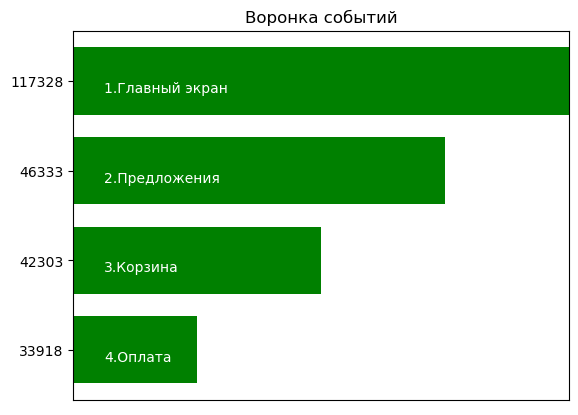

In [91]:
x = [117328,46333,42303,33918]
x.reverse()
labels =  ["1.Главный экран","2.Предложения", "3.Корзина", "4.Оплата"]
labels.reverse()

fig, ax = plt.subplots()
width = 0.75 # the width of the bars
ind = np.arange(len(y))  # the x locations for the groups
bar_plot = ax.barh(ind, y, width, color="green", align='edge')
ax.set_yticks(ind+width/2)
ax.set_yticklabels(x, minor=False)
plt.xticks(np.arange(0),(''))

def autolabel(bar_plot):
    for idx,rect in enumerate(bar_plot):
        ax.text(0.25, idx+.25, labels[idx], color = 'white')
autolabel(bar_plot)

plt.margins(0,0.05)
plt.title('Воронка событий')
plt.ylabel('')

plt.show()

На втором шаге мы теряем больше всего пользователей - 38%.
От первого события до оплаты доходит 48% пользователей и 95% тех, кто добавил товар в корзину.

На этом шаге мы построили воронку событий и изучили ее. На следующем шаге изучим результаты эксперимента

## Шаг: Изучим результаты эксперимента

### Сколько пользователей в каждой экспериментальной группе?

In [24]:
# Сколько пользователей в каждой экспериментальной группе?
users_gr=logs_f.groupby('group')['device'].nunique()
users_gr

group
246    2483
247    2512
248    2535
Name: device, dtype: int64

В каждой группе примерно одинаковое количество пользователей

### Есть 2 контрольные группы для А/А-эксперимента, чтобы проверить корректность всех механизмов и расчётов. Проверим, находят ли статистические критерии разницу между выборками 246 и 247.

Вначале подготовим таблицу для дальнейшего анализа

In [25]:
# состатвим сводную таблицу событий по группам
dev_events = logs_f.pivot_table(index='group',columns='event', values='device', aggfunc='nunique').reset_index()
# добавим общую сумму пользователей в таблицу
dev_events['all_users'] = dev_events['group'].apply(lambda x: users_gr.loc[x])
# изменим индекс на группу
dev_events = dev_events.set_index('group')
# добавим общую группу А (246+247)
#сложим события пользоватлей 246 и 247
new_row = dev_events.loc[246] + dev_events.loc[247]
new_row.name='246&247'
# добавим строчку в таблицу
dev_events = dev_events.append([new_row])
# переиндексируем
dev_events = dev_events.reindex([246, 247, '246&247', 248])
display(dev_events)

event,CartScreenAppear,MainScreenAppear,OffersScreenAppear,PaymentScreenSuccessful,all_users
group,,,,,
246,1266,2450,1542,1200,2483
247,1238,2476,1520,1158,2512
246&247,2504,4926,3062,2358,4995
248,1230,2493,1531,1181,2535


In [26]:
# создадим функции для проверки, уровень значимости 0.1 или 0.05 будем передавать при вызове
def test(first, second, all_f, all_s, al):  
    alpha = al  # критический уровень статистической значимости
    p1 = first / all_f 
    p2 = second / all_s 
    p_combined = (first + second) / (all_f + all_s) 
    difference = p1 - p2 
    z_value = difference / mth.sqrt(p_combined * (1 - p_combined) * (1/all_f + 1/all_s))
    # задаем стандартное нормальное распределение (среднее 0, ст.отклонение 1)
    distr = st.norm(0, 1) 
    p_value = (1 - distr.cdf(abs(z_value))) * 2
    if p_value < al:
        result='Отвергаем нулевую гипотезу'
    else:
        result='Не получилось отвергнуть нулевую гипотезу'
    return print('Событие',event,'группы',gr_1,'и',gr_2, 'alpha=',al,' p-value=',round(p_value,4), result)
# список событий
events_name = logs_f['event'].unique()

In [27]:
print('Гипотезы:')
print('H0: статистически значимых различий между группами нет')
print('H1: статистически значимые различия между группами есть')

Гипотезы:
H0: статистически значимых различий между группами нет
H1: статистически значимые различия между группами есть


In [28]:
gr_1 = 246
gr_2 = 247
current_row = dev_events.loc[gr_1]
al=0.05 # уровень значимости 0.05
print('Проверяем группы А 246 и 247 при уровне значимости', al)
for event in events_name:
    test(current_row[event],dev_events[event][gr_2],current_row['all_users'],dev_events['all_users'][gr_2],al)

Проверяем группы А 246 и 247 при уровне значимости 0.05
Событие MainScreenAppear группы 246 и 247 alpha= 0.05  p-value= 0.7527 Не получилось отвергнуть нулевую гипотезу
Событие OffersScreenAppear группы 246 и 247 alpha= 0.05  p-value= 0.2479 Не получилось отвергнуть нулевую гипотезу
Событие CartScreenAppear группы 246 и 247 alpha= 0.05  p-value= 0.2287 Не получилось отвергнуть нулевую гипотезу
Событие PaymentScreenSuccessful группы 246 и 247 alpha= 0.05  p-value= 0.1145 Не получилось отвергнуть нулевую гипотезу


In [29]:
gr_1 = 246
gr_2 = 247
current_row = dev_events.loc[gr_1]
al=0.1 # уровень значимости 0.1
print('Проверяем группы А 246 и 247 при уровне значимости', al)
for event in events_name:
    test(current_row[event],dev_events[event][gr_2],current_row['all_users'],dev_events['all_users'][gr_2],al)

Проверяем группы А 246 и 247 при уровне значимости 0.1
Событие MainScreenAppear группы 246 и 247 alpha= 0.1  p-value= 0.7527 Не получилось отвергнуть нулевую гипотезу
Событие OffersScreenAppear группы 246 и 247 alpha= 0.1  p-value= 0.2479 Не получилось отвергнуть нулевую гипотезу
Событие CartScreenAppear группы 246 и 247 alpha= 0.1  p-value= 0.2287 Не получилось отвергнуть нулевую гипотезу
Событие PaymentScreenSuccessful группы 246 и 247 alpha= 0.1  p-value= 0.1145 Не получилось отвергнуть нулевую гипотезу


Мы проверили обе группы А при разных уровнях статистической значимости 0.05 и 0.1, статистически значимых различий между группами 246 и 247 нет. Разбивка на группы была произведена корректно.

### Выберем самое популярное событие. Посчитаем число пользователей, совершивших это событие в каждой из контрольных групп. Посчитаем долю пользователей, совершивших это событие. Проверим, будет ли отличие между группами статистически достоверным. 

In [30]:
display(dev_events)

event,CartScreenAppear,MainScreenAppear,OffersScreenAppear,PaymentScreenSuccessful,all_users
group,,,,,
246,1266,2450,1542,1200,2483
247,1238,2476,1520,1158,2512
246&247,2504,4926,3062,2358,4995
248,1230,2493,1531,1181,2535


Самое популярное событие у всех групп - просмотр главного экрана (MainScreenAppear)

In [31]:
# доля пользователей самого популярного события
dev_events['dolya']=dev_events['MainScreenAppear']/dev_events['all_users']
display(dev_events[['MainScreenAppear','dolya']])

event,MainScreenAppear,dolya
group,,
246,2450,0.986710
247,2476,0.985669
246&247,4926,0.986186
248,2493,0.983432


In [32]:
# Проверим будет ли отличие между группами по событию MainScreenAppear статистически достоверным.
event='MainScreenAppear'
gr_2=248
for i in range(3):
    gr_1 = dev_events.index[i]
    current_row = dev_events.loc[gr_1]
    al=0.05 # уровень значимости 0.05
    print('Проверяем группы А', gr_1, 'и', gr_2, ' при уровне значимости', al, 'по событию MainScreenAppear')
    test(current_row[event],dev_events[event][gr_2],current_row['all_users'],dev_events['all_users'][gr_2],al)
print('--------------------------------------')    
for i in range(3):
    gr_1 = dev_events.index[i]
    current_row = dev_events.loc[gr_1]    
    al=0.1 # уровень значимости 0.05
    print('Проверяем группы А', gr_1, 'и', gr_2, ' при уровне значимости', al, 'по событию MainScreenAppear')
    test(current_row[event],dev_events[event][gr_2],current_row['all_users'],dev_events['all_users'][gr_2],al)

Проверяем группы А 246 и 248  при уровне значимости 0.05 по событию MainScreenAppear
Событие MainScreenAppear группы 246 и 248 alpha= 0.05  p-value= 0.3387 Не получилось отвергнуть нулевую гипотезу
Проверяем группы А 247 и 248  при уровне значимости 0.05 по событию MainScreenAppear
Событие MainScreenAppear группы 247 и 248 alpha= 0.05  p-value= 0.5195 Не получилось отвергнуть нулевую гипотезу
Проверяем группы А 246&247 и 248  при уровне значимости 0.05 по событию MainScreenAppear
Событие MainScreenAppear группы 246&247 и 248 alpha= 0.05  p-value= 0.3487 Не получилось отвергнуть нулевую гипотезу
--------------------------------------
Проверяем группы А 246 и 248  при уровне значимости 0.1 по событию MainScreenAppear
Событие MainScreenAppear группы 246 и 248 alpha= 0.1  p-value= 0.3387 Не получилось отвергнуть нулевую гипотезу
Проверяем группы А 247 и 248  при уровне значимости 0.1 по событию MainScreenAppear
Событие MainScreenAppear группы 247 и 248 alpha= 0.1  p-value= 0.5195 Не получи

По событию просмотр главного экрана между группами нет статистически достоверных отличий, провера проводилась при уровне значимости 0.05 и 0.1

### Аналогично поступите с группой с изменённым шрифтом. Сравним результаты с каждой из контрольных групп в отдельности по каждому событию. Сравним результаты с объединённой контрольной группой. 

Проверим теперь отстальные события

In [33]:
gr_2=248
for event in events_name:
    if event=='MainScreenAppear':
        continue
    for i in range(3):
        gr_1 = dev_events.index[i]
        current_row = dev_events.loc[gr_1]
        al=0.05 # уровень значимости 0.05
        print('Проверяем группы А', gr_1, 'и', gr_2, ' при уровне значимости', al, 'по событию', event)
        test(current_row[event],dev_events[event][gr_2],current_row['all_users'],dev_events['all_users'][gr_2],al)
print('-----')
for event in events_name:
    if event=='MainScreenAppear':
        continue
    for i in range(3):
        gr_1 = dev_events.index[i]
        current_row = dev_events.loc[gr_1]
        al=0.1 # уровень значимости 0.1
        print('Проверяем группы А', gr_1, 'и', gr_2, ' при уровне значимости', al, 'по событию', event)
        test(current_row[event],dev_events[event][gr_2],current_row['all_users'],dev_events['all_users'][gr_2],al)  


Проверяем группы А 246 и 248  при уровне значимости 0.05 по событию OffersScreenAppear
Событие OffersScreenAppear группы 246 и 248 alpha= 0.05  p-value= 0.2144 Не получилось отвергнуть нулевую гипотезу
Проверяем группы А 247 и 248  при уровне значимости 0.05 по событию OffersScreenAppear
Событие OffersScreenAppear группы 247 и 248 alpha= 0.05  p-value= 0.9334 Не получилось отвергнуть нулевую гипотезу
Проверяем группы А 246&247 и 248  при уровне значимости 0.05 по событию OffersScreenAppear
Событие OffersScreenAppear группы 246&247 и 248 alpha= 0.05  p-value= 0.4458 Не получилось отвергнуть нулевую гипотезу
Проверяем группы А 246 и 248  при уровне значимости 0.05 по событию CartScreenAppear
Событие CartScreenAppear группы 246 и 248 alpha= 0.05  p-value= 0.0807 Не получилось отвергнуть нулевую гипотезу
Проверяем группы А 247 и 248  при уровне значимости 0.05 по событию CartScreenAppear
Событие CartScreenAppear группы 247 и 248 alpha= 0.05  p-value= 0.5878 Не получилось отвергнуть нулевую

При анализе результатов видим, что они практически сопадают при разных уровнях значимости, отличие есть лишь между группами 246 и 248 по событию просмотр корзины (CartScreenAppear) при уровне значимости 0.1.

Для сравнения тесты были проведены с уровнями значимости 0.05 и 0.1

По каждому из уровней значимости было произведено по 16 проверок гипотез. При уровне значимости 0.1 выявилось различие между группами 246 и 248, учистывая количесво проведенных проверок, это отличие очень похоже на ложный результат. Вывод: стоит опираться и применять в данном исследовании уровень значимости 0.05, который показал, что различий между группами нет.

<b> Выводы </b>

При анализе результатов теста было вявлено следующее:<br>
   * Разбивка пользователей на группы была проведена корректо
   * Уровень статистической значиости был выбран 0.05, т.к в результате большого числа проверок гипотез значимость 0.1 может давать ошибки
   * При выбранном уровне значимости 0.05 нет статистически значимых различий между пользователями с новыми и старыми шрифтами, <b>нет смысла менять шрифты</b> <br>
Анализ воронки событий показал, что:
   * 48% пользователей доходят до оплаты и 95% положивших товар в корзину оплачивают его, это неплохой показатель.
   * Больше всего пользователей (38%) теряется при переходе с первого шага на второй, возможно стоит <b>разместить рекламные баннеры и ссылки на главной странице</b>, привлекающими внимание и завлекающими пользователей на дальнейшие страницы.